### Example 1b: Linear convection in 2D, revisited

We will now revisit the fhe first example of this tutorial with an example that is better suited to the numerical scheme used in Devito. As a reminder, the governing equation is:

$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0$$

We then discretized this using forward differences in time and backward differences in space:

$$u_{i,j}^{n+1} = u_{i,j}^n-c \frac{\Delta t}{\Delta x}(u_{i,j}^n-u_{i-1,j}^n)-c \frac{\Delta t}{\Delta y}(u_{i,j}^n-u_{i,j-1}^n)$$

In the previous example, the system was initialised with a hat function. As easy as this example seems, it actually highlights a few limitations of finite differences and related methods:
 - The governing equation above contains spatial derivatives ($\frac{\partial u}{\partial x}$ and $\frac{\partial u}{\partial y}$). The hat, with its sharp corners, is discontinuous and therefore non-smooth, meaning that the derivatives do not exist at the corners of the hat. This means that the governing equation has no solution in the strict sense for this problem. Mathematically, this problem can be overcome by introducing weak solutions, which still exist in the presence of discontinuities, as long as the problem is smooth almost everywhere. The Finite Volume (FV), Finite Element (FEM) and related schemes are based on this weak form.
 - The finite differences method only works well if finite differences are a good approximation of the derivatives. With the chosen discretisation above, this requires that $\frac{u_{i,j}^n-u_{i-1,j}^n}{\Delta x} \approx \frac{\partial u}{\partial x}$ and $\frac{u_{i,j}^n-u_{i,j-1}^n}{\Delta y} \approx \frac{\partial u}{\partial y}$. This is the case for systems with a smooth solution if $\Delta x$ and $\Delta y$ are sufficiently small. But if the solution is non-smooth, as in this example, then we can't expect much regardless of the grid size.
 - First-order methods, such as the backward differences that we have used in this exampe, are known to create artificial diffusion. Higher-order schemes, such as central differences, avoid this problem. However, in the presence of discontinuities these methods introduce so-called spurious oscillations. These oscillations may even build up (grow infinitely) and cause the computation to diverge.
 - Discontinuities can appear by themselves for some equations (such as the Burgers equation that we discuss next), even if the intial condition is smooth. In CFD, discontinuities appear for example as shocks in the simulation of transonic flow. For this reason, numerical schemes that behave well in the presence of discontinuities have been a research subject for a long time. A thorough discussion is beyond the scope of this tutorial, but can be found in [R. LeVeque (1992): Numerical Methods for Conservation Laws, 2nd ed., Birkhäuser Verlag, pp. 8-13].
 
In the remainder of this example, we will reproduce the results from the previous example, only this time with a smooth initial condition. This lets us observe Devito in a setting for which it is better equipped.
 

In [1]:
from examples.cfd import plot_field, init_hat, init_smooth
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 81
ny = 81
nt = 100
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
sigma = .2
dt = sigma * dx

Let us now initialise the field with an infinitely smooth bump, as given by [J.A. Krakos (2012): Unsteady Adjoint Analysis for Output Sensitivity
and Mesh Adaptation, PhD thesis, p. 68] as $$
f(r)=
\begin{cases}
\frac{1}{A}e^{-1/(r-r^2)} &\text{ for } 0 < r < 1,\\
0 &\text{ else.}
\end{cases}
$$
We use this with $A=100$, and define the initial condition in two dimensions as $$u^0(x,y)=1+f\left(\frac{2}{3}x\right)*f\left(\frac{2}{3}y\right).$$

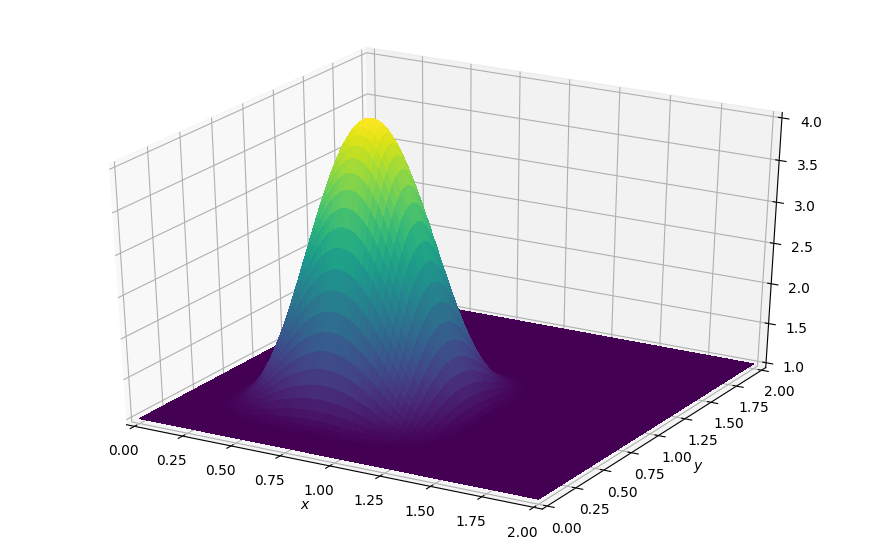

In [2]:
#NBVAL_IGNORE_OUTPUT

# Create field and assign initial conditions
u = np.empty((nx, ny))
init_smooth(field=u, dx=dx, dy=dy)

# Plot initial condition
plot_field(u, zmax=4)

Solving this will again move the bump.

In [3]:
# Repeat initialisation, so we can re-run the cell
init_smooth(field=u, dx=dx, dy=dy)

for n in range(nt + 1):
    # Copy previous result into a new buffer
    un = u.copy()
    
    # Update the new result with a 3-point stencil
    u[1:, 1:] = (un[1:, 1:] - (c * dt / dx * (un[1:, 1:] - un[1:, :-1])) -
                              (c * dt / dy * (un[1:, 1:] - un[:-1, 1:])))

    # Apply boundary conditions
    u[0, :] = 1.
    u[-1, :] = 1.
    u[:, 0] = 1.
    u[:, -1] = 1.

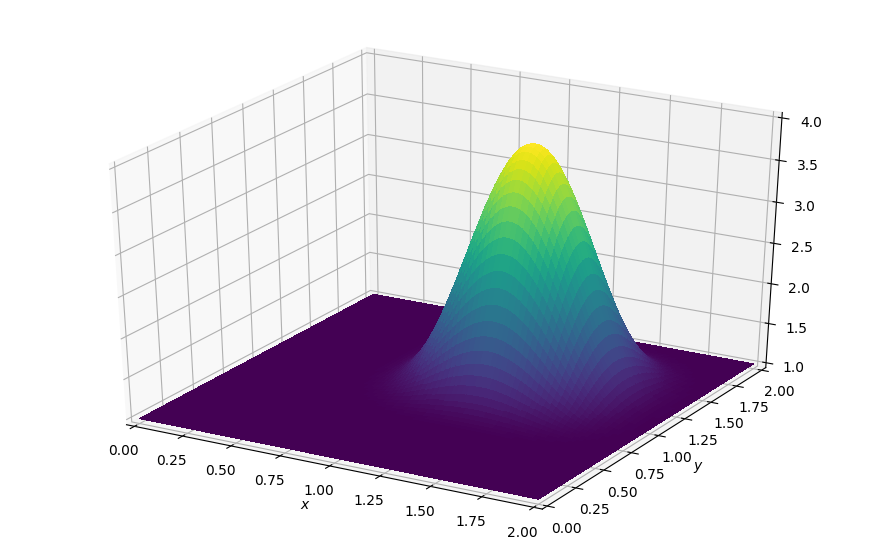

In [4]:
#NBVAL_IGNORE_OUTPUT

# A small sanity check for auto-testing
assert (u[45:55, 45:55] > 1.8).all()
u_ref = u.copy()

plot_field(u, zmax=4.)

Hooray, the wave moved! It looks like the solver works much better for this example: The wave has not noticeably changed its shape.

#### Devito implementation
Again, we can re-create this via a Devito operator. Let's fill the initial buffer with smooth data and look at it:

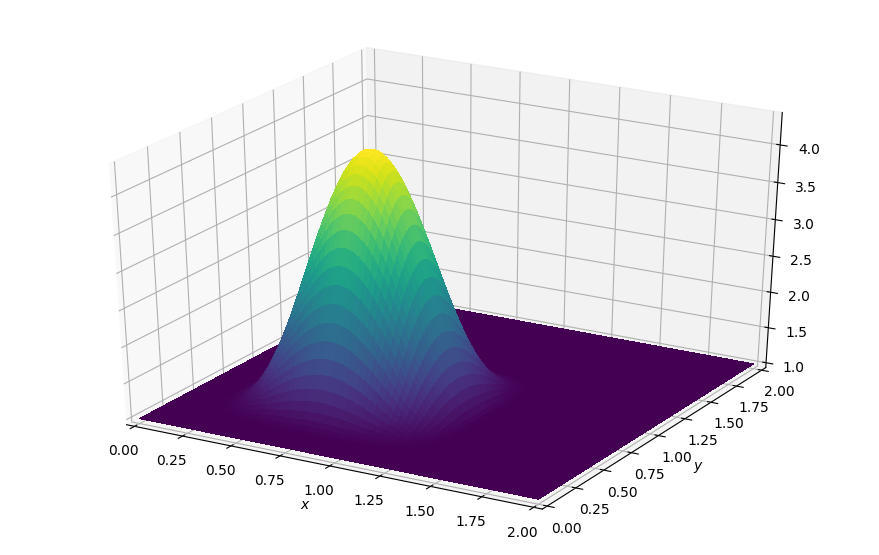

In [5]:
#NBVAL_IGNORE_OUTPUT
from devito import Grid, TimeFunction, INTERIOR

grid = Grid(shape=(nx, ny), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)
init_smooth(field=u.data[0], dx=dx, dy=dy)

plot_field(u.data[0])

We again create the discretised equation as shown below. Note that the equation is still the same, only the initial condition has changed.

In [6]:
from devito import Eq

eq = Eq(u.dt + c*u.dxl + c*u.dyl)

print(eq)

Eq(1.0*u(t, x, y)/h_y - 1.0*u(t, x, y - h_y)/h_y + 1.0*u(t, x, y)/h_x - 1.0*u(t, x - h_x, y)/h_x - u(t, x, y)/dt + u(t + dt, x, y)/dt, 0)


SymPy can re-organise this equation just like in the previous example.

In [7]:
from sympy import solve

stencil = solve(eq, u.forward, rational=False)[0]

print(stencil)

(1.0*dt*h_x*(-u(t, x, y) + u(t, x, y - h_y)) + 1.0*dt*h_y*(-u(t, x, y) + u(t, x - h_x, y)) + h_x*h_y*u(t, x, y))/(h_x*h_y)


We can now use this stencil expression to create an operator to apply to our data object:

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sgpz_dd7/01ce617a52ebc561dcc4742e8bd4a2a2fc7db834.c [1.49 s]
Section main<101,80,80> with OI=1.62 computed in 0.000 s [20.96 GFlops/s, 1.61 GPts/s]


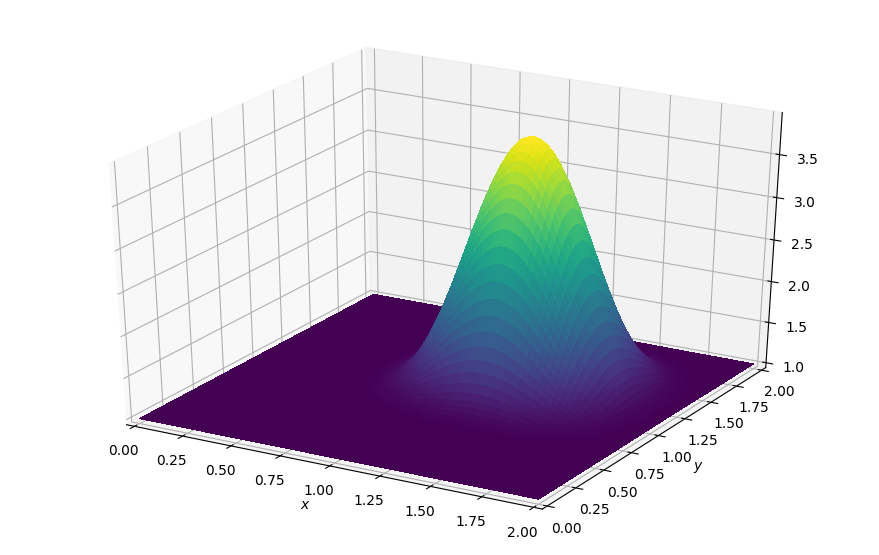

In [8]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

# Reset our initial condition in both buffers.
# This is required to avoid 0s propagating into
# our solution, which has a background value of 1.
init_smooth(field=u.data[0], dx=dx, dy=dy)
init_smooth(field=u.data[1], dx=dx, dy=dy)

# Apply boundary conditions
u.data[:, 0, :] = 1.
u.data[:, -1, :] = 1.
u.data[:, :, 0] = 1.
u.data[:, :, -1] = 1.
    
# Create an operator that updates the forward stencil
# point to the interior region only.
op = Operator(Eq(u.forward, stencil, region=INTERIOR))

# Apply the operator for a number of timesteps
op(time=nt, dt=dt)

plot_field(u.data[0, :, :])

# Some small sanity checks for the testing framework
assert (u.data[0, 45:55, 45:55] > 1.8).all()
assert np.allclose(u.data[0], u_ref, rtol=3.e-2)

Again, this looks just like the result from NumPy. Since this example is just like the one before, the low-level treatment of boundaries is also unchanged.

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sgpz_dd7/87a5c62fcc10ded6e3b0f92e6e2ec7e3f815a6e7.c [0.68 s]
Section section_1<101,81> with OI=0.00 computed in 0.000 s [0.00 GFlops/s]
Section section_2<101,81> with OI=0.00 computed in 0.000 s [0.00 GFlops/s]
Section main<101,79,79> with OI=1.75 computed in 0.001 s [9.96 GFlops/s, 0.71 GPts/s]


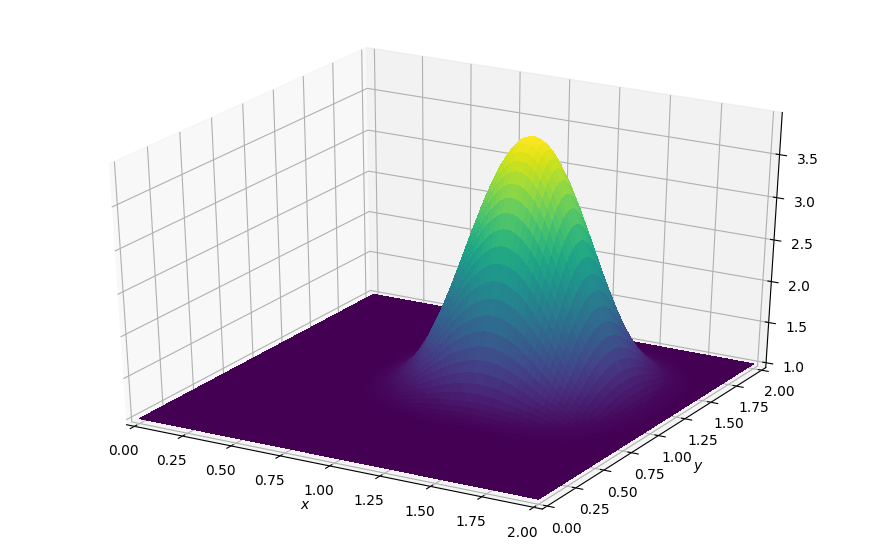

In [9]:
#NBVAL_IGNORE_OUTPUT

# Reset our data field and ICs in both buffers
init_smooth(field=u.data[0], dx=dx, dy=dy)
init_smooth(field=u.data[1], dx=dx, dy=dy)

# For defining BCs, we generally to explicitly set rows/columns
# in our field using an expression. We can use Devito's "indexed" 
# notation to do this:
x, y = grid.dimensions
t = grid.stepping_dim
bc_left = Eq(u.indexed[t + 1, 0, y], 1.)
bc_right = Eq(u.indexed[t + 1, nx-1, y], 1.)
bc_top = Eq(u.indexed[t + 1, x, ny-1], 1.)
bc_bottom = Eq(u.indexed[t + 1, x, 0], 1.)

# Now combine the BC expressions with the stencil to form operator.
expressions = [Eq(u.forward, stencil, region=INTERIOR)]
expressions += [bc_left, bc_right, bc_top, bc_bottom]
op = Operator(expressions=expressions, dle=None, dse=None)  # <-- Turn off performance optimisations
op(time=nt, dt=dt)

plot_field(u.data[0, :, :])

# Some small sanity checks for the testing framework
assert (u.data[0, 45:55, 45:55] > 1.8).all()
assert np.allclose(u.data[0], u_ref, rtol=3.e-2)

The C code of the Kernel is also still the same.

In [10]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"

struct profile
{
  double section_0;
  double section_1;
  double section_2;
} ;


int Kernel(const float dt, const float h_x, const float h_y, float *restrict u_vec, const int time_M, const int time_m, void *_timers, const int x_M, const int x_m, const int x_size, const int xi_M, const int xi_m, const int y_M, const int y_m, const int y_size, const int yi_M, const int yi_m)
{
  float (*restrict u)[x_size + 1 + 1][y_size + 1 + 1] __attribute__((aligned(64))) = (float (*)[x_size + 1 + 1][y_size + 1 + 1]) u_vec;
  struct profile *timers = (struct profile*) _timers;
  for (int time = time_m, t0 = (time)%(2), t1 = (time + 1)%(2); time <= time_M; time += 1, t0 = (time)%(2), t1 = (time + 1)%(2))
  {
    struct timeval start_section_0, end_section_0;
    gettimeofday(&start_section_0, NULL);
    for (int xi = xi_m; xi <= xi_M; xi += 1)
    {
      for (int yi = yi_m; yi <= yi_M; yi += 1)
      {
     